# **Introduction**

Dans ce projet, nous allons fine-tuner le modèle de langage **Llama3 8b instruct** en utilisant le dataset **Instruction-Poems**. L'objectif est de créer un modèle capable de générer des poèmes cohérents, créatifs, et adaptés à des instructions spécifiques. Ce projet implique une exploration approfondie des données, un nettoyage méthodique, une préparation minutieuse pour l'entraînement, et une évaluation rigoureuse des performances du modèle.

### Plan de travail
1. **Exploration des données** : Analyser le dataset **Instruction-Poems** pour identifier les spécificités, les anomalies, et les opportunités d'amélioration. L'objectif est de bien comprendre la structure des instructions et des poèmes.
2. **Nettoyage des données** : Éliminer les exemples inutilisables ou mal formatés, corriger les incohérences et garantir un format standardisé pour chaque instruction et son poème associé.
3. **Préparation des données** : Tokenisation, normalisation des textes et séparation en ensembles d'entraînement et de validation, tout en préservant un équilibre entre les différents types d'instructions.
4. **Fine-tuning du modèle** : Adapter le modèle **Llama3--8B** pour qu'il excelle dans la génération de poèmes basés sur des instructions données. Nous utiliserons des techniques comme le fine-tuning supervisé (SFT) et des méthodes de fine-tuning efficaces comme LoRA pour optimiser les ressources.
5. **Évaluation des performances** : Mesurer la qualité des poèmes générés à l'aide de métriques adaptées telles que BLEU, ROUGE, et des évaluations humaines pour juger de la créativité et de la pertinence des résultats.

#**1. Exploration des données**

Installation des Dépendances Nécessaires

In [ ]:
!pip install transformers[torch] datasets

In [ ]:
!pip install bitsandbytes trl peft tqdm

In [ ]:
!pip install accelerate tqdm rouge-score

In [ ]:
!pip install flash-attn --no-build-isolation

Chargement des Bibliothèques

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datasets import load_dataset

Chargement des Jeux de Données

In [ ]:
ds = load_dataset("checkai/instruction-poems")

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['INSTRUCTION', 'RESPONSE', 'SOURCE', 'METADATA'],
        num_rows: 13854
    })
})

Conversion de `df` en DataFrame

In [ ]:
df = pd.DataFrame(ds['train'])

In [ ]:
df.head()

,INSTRUCTION,RESPONSE,SOURCE,METADATA
0,"Compose a poem, about Living,Death,The Body,Na...","I've written a poem for you about Living,Death...",PoetryFoundation.org - kari edwards,"{""author"": ""kari edwards"", ""title"": ""\""[ready ..."
1,"Make a poem with themes of Religion,Faith & Do...","Here's a beautiful poem about Religion,Faith &...",PoetryFoundation.org - Thomas P. Lynch,"{""author"": ""Thomas P. Lynch"", ""title"": ""\""Argy..."
2,"Make a poem with themes of Religion,Faith & Do...","Sure, I can do that. Here's a poem about Relig...",PoetryFoundation.org - Robert Bly,"{""author"": ""Robert Bly"", ""title"": ""\""Wanting S..."
3,"Write me a poem about Religion,Faith & Doubt,G...","Here's a poem I composed about Religion,Faith ...",PoetryFoundation.org - Sheena Raza Faisal,"{""author"": ""Sheena Raza Faisal"", ""title"": ""\""a..."
4,"Write me a poem about Living,Growing Old,Natur...","It's called ""February Evening in New York"": \n...",PoetryFoundation.org - Denise Levertov,"{""author"": ""Denise Levertov"", ""title"": ""\""Febr..."


In [ ]:
df.shape

(13854, 4)

À cette étape, nous divisons le dataset `df` en ensembles d'entraînement, de test et de validation.

In [ ]:
train_df, test_df, validation_df = np.split(df.sample(frac=1, random_state=42), [int(.8*len(df)), int(.9*len(df))])

/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [ ]:
train_df.shape, test_df.shape, validation_df.shape

((11083, 4), (1385, 4), (1386, 4))

Dans cette étape, nous sélectionnons un sous-ensemble de l'ensemble d'entraînement. Cela permet de réduire la taille des données pour un traitement plus rapide lors des phases de développement et de test.

In [ ]:
train_df = train_df.sample(frac=0.19, random_state=42)

In [ ]:
train_df.shape

(2106, 4)

In [ ]:
test_df= test_df.sample(frac=0.1, random_state=42)
test_df.shape

(138, 4)

In [ ]:
validation_df= validation_df.sample(frac=0.1, random_state=42)
validation_df.shape

(139, 4)

Afficher un aperçu des datasets

In [ ]:
train_df.head()

,INSTRUCTION,RESPONSE,SOURCE,METADATA
7187,Make a poem with themes of Social Commentaries...,"Okay, a poem about Social Commentaries,Cities ...",PoetryFoundation.org - Louise Imogen Guiney,"{""author"": ""Louise Imogen Guiney"", ""title"": ""\..."
12947,"Make a poem with themes of Living,Nature,Anima...","Sure, I can do that. Here's a poem about Livin...",PoetryFoundation.org - Knar Gavin,"{""author"": ""Knar Gavin"", ""title"": ""\""Statocyst..."
10935,"Compose a poem, about Living,Infancy,Parenthoo...","Of course! It's called ""Tinnitus: May, low ski...",PoetryFoundation.org - David Harsent,"{""author"": ""David Harsent"", ""title"": ""\""Tinnit..."
2721,"Make a poem with themes of Activities,Jobs & W...","Here's a beautiful poem about Activities,Jobs ...",PoetryFoundation.org - David Rivard,"{""author"": ""David Rivard"", ""title"": ""\""Torque\..."
10409,"Can you write a poem? Make it about Living,Gro...","Here's a beautiful poem about Living,Growing O...",PoetryFoundation.org - Larry Levis,"{""author"": ""Larry Levis"", ""title"": ""\""Winter S..."


In [ ]:
test_df.head()

,INSTRUCTION,RESPONSE,SOURCE,METADATA
12086,"I want a poem about Activities,Travels & Journ...","I've written a poem for you about Activities,T...",PoetryFoundation.org - Douglas Kearney,"{""author"": ""Douglas Kearney"", ""title"": ""\""Afro..."
13246,Title this poem: \nI\r\n\r\nThe spider expects...,"How about calling it ""The Spider""?",PoetryFoundation.org - Richard Eberhart,"{""author"": ""Richard Eberhart"", ""title"": ""\""The..."
5901,"Make a poem with themes of Living,Love,Relatio...","Of course! It's called ""The Window"": \nyou are...",PoetryFoundation.org - Diane di Prima,"{""author"": ""Diane di Prima"", ""title"": ""\""The W..."
5420,"Compose a poem, about Living,Death,Marriage & ...","I've written a poem for you about Living,Death...",PoetryFoundation.org - Donald Davie,"{""author"": ""Donald Davie"", ""title"": ""\""No Epit..."
3493,"Compose a poem, about Love,Break-ups & Vexed L...","I've written a poem for you about Love,Break-u...",PoetryFoundation.org - Edmund Spenser,"{""author"": ""Edmund Spenser"", ""title"": ""\""Amore..."


In [ ]:
validation_df.head()

,INSTRUCTION,RESPONSE,SOURCE,METADATA
1542,"Compose a poem, about Life Choices,Arts & Scie...","Of course! It's called ""The God Called Poetry""...",PoetryFoundation.org - Robert Graves,"{""author"": ""Robert Graves"", ""title"": ""\""The Go..."
260,"Can you write a poem? Make it about Living,Dea...","Of course! It's called ""Immortality Ode"": \nMi...",PoetryFoundation.org - Bruce Smith,"{""author"": ""Bruce Smith"", ""title"": ""\""Immortal..."
7455,"Compose a poem, about Religion,God & the Divin...","It's called ""Reemergence of the Noose"": \nSome...",PoetryFoundation.org - Patricia Smith,"{""author"": ""Patricia Smith"", ""title"": ""\""Reeme..."
7651,"I want a poem about Activities,Travels & Journ...","Here's your poem about Activities,Travels & Jo...",PoetryFoundation.org - Mark Rudman,"{""author"": ""Mark Rudman"", ""title"": ""\""Provo\""""..."
10262,"Write me a poem about Living,Death,Parenthood,...","I've written a poem for you about Living,Death...",PoetryFoundation.org - Mary Karr,"{""author"": ""Mary Karr"", ""title"": ""\""Requiem fo..."


Exploration de Quelques Lignes de Notre Dataset d’Entraînement

In [ ]:
train_df['INSTRUCTION'][7187]

'Make a poem with themes of Social Commentaries,Cities & Urban Life.Generate a poem with the following themes: Social Commentaries,Cities & Urban Life.'

In [ ]:
train_df['RESPONSE'][7187]

'Okay, a poem about Social Commentaries,Cities & Urban Life: \n"The Lights of London"\nThe evenfall, so slow on hills, hath shot Far down into the valley’s cold extreme, Untimely midnight; spire and roof and stream Like fleeing specters, shudder and are not. The Hampstead hollies, from their sylvan plot Yet cloudless, lean to watch as in a dream, From chaos climb with many a sudden gleam, London, one moment fallen and forgot. Her booths begin to flare; and gases bright Prick door and window; all her streets obscure Sparkle and swarm with nothing true nor sure, Full as a marsh of mist and winking light; Heaven thickens over, Heaven that cannot cure Her tear by day, her fevered smile by night.'

In [ ]:
train_df['SOURCE'][7187]

'PoetryFoundation.org - Louise Imogen Guiney'

In [ ]:
train_df['METADATA'][7187]

'{"author": "Louise Imogen Guiney", "title": "\\"The Lights of London\\"", "tags": "Social Commentaries,Cities & Urban Life", "task_type": "writing"}'

Comme on peut le remarquer, `METADATA` ne sera pas vraiment utile pour l'entraînement de notre modèle, contrairement à `RESPONSE`, `SOURCE` et `INSTRUCTION`, que nous allons conserver pour l'entraînement.

Nous allons concaténer `Response` et `Source` pour déterminer, pour chaque poème généré, sa source.

In [ ]:
response = f"{train_df['RESPONSE'][7187]} \nSource: {train_df['SOURCE'][7187]}"

In [ ]:
print(response)

Okay, a poem about Social Commentaries,Cities & Urban Life: 
"The Lights of London"
The evenfall, so slow on hills, hath shot Far down into the valley’s cold extreme, Untimely midnight; spire and roof and stream Like fleeing specters, shudder and are not. The Hampstead hollies, from their sylvan plot Yet cloudless, lean to watch as in a dream, From chaos climb with many a sudden gleam, London, one moment fallen and forgot. Her booths begin to flare; and gases bright Prick door and window; all her streets obscure Sparkle and swarm with nothing true nor sure, Full as a marsh of mist and winking light; Heaven thickens over, Heaven that cannot cure Her tear by day, her fevered smile by night. 
Source: PoetryFoundation.org - Louise Imogen Guiney


In [ ]:
for index, row in train_df.iterrows():
  i = index
  train_df.loc[index, 'RESPONSE'] = f"{row['RESPONSE']} \nSource: {row['SOURCE']}"

In [ ]:
for index, row in test_df.iterrows():
  i = index
  test_df.loc[index, 'RESPONSE'] = f"{row['RESPONSE']} \nSource: {row['SOURCE']}"

In [ ]:
for index, row in validation_df.iterrows():
  i = index
  validation_df.loc[index, 'RESPONSE'] = f"{row['RESPONSE']} \nSource: {row['SOURCE']}"

In [ ]:
print(train_df['RESPONSE'][7187])

Okay, a poem about Social Commentaries,Cities & Urban Life: 
"The Lights of London"
The evenfall, so slow on hills, hath shot Far down into the valley’s cold extreme, Untimely midnight; spire and roof and stream Like fleeing specters, shudder and are not. The Hampstead hollies, from their sylvan plot Yet cloudless, lean to watch as in a dream, From chaos climb with many a sudden gleam, London, one moment fallen and forgot. Her booths begin to flare; and gases bright Prick door and window; all her streets obscure Sparkle and swarm with nothing true nor sure, Full as a marsh of mist and winking light; Heaven thickens over, Heaven that cannot cure Her tear by day, her fevered smile by night. 
Source: PoetryFoundation.org - Louise Imogen Guiney


In [ ]:
train_df = train_df[['INSTRUCTION',	'RESPONSE']]
test_df = test_df[['INSTRUCTION',	'RESPONSE']]
validation_df = validation_df[['INSTRUCTION',	'RESPONSE']]

**Vérification des valeurs manquantes**

In [ ]:
train_df.isnull().sum()

,0
INSTRUCTION,0
RESPONSE,0


In [ ]:
test_df.isnull().sum()

,0
INSTRUCTION,0
RESPONSE,0


In [ ]:
validation_df.isnull().sum()

,0
INSTRUCTION,0
RESPONSE,0


D'après ces résultats, on peut bien remarquer qu'aucune valeur manquante n'a été détectée dans les colonnes `INSTRUCTION` et `RESPONSE` des ensembles d'entraînement, de test, et de validation. Cela garantit que le dataset est complet et prêt pour les étapes suivantes.

**Description statistique des colonnes du dataset d'entraînement**

In [ ]:
train_desciption = train_df.describe()

In [ ]:
train_desciption

,INSTRUCTION,RESPONSE
count,2106,2106
unique,1813,2106
top,Compose a poem.,"Here's your poem about Living,Time & Brevity,N..."
freq,26,1


**Affichage des instruction et de la reponse les plus fréquents**

In [ ]:
top_INSTRUCTION = train_desciption['INSTRUCTION'].iloc[2]
print("Top INSTRUCTION :", top_INSTRUCTION)

Top INSTRUCTION : Compose a poem.


**1. Analyse de la colonne `INSTRUCTION`**
- **Count** : La colonne contient **2106 instructions**, ce qui correspond au nombre total d'entrées dans le dataset.
- **Unique** : Elle compte **1813 instructions uniques**, ce qui montre qu'il existe des doublons dans les instructions.
- **Top** : L'instruction la plus fréquente est **`Compose a poem.`**, qui est une demande générique pour un poème.
- **Frequency** : Cette instruction apparaît **26 fois**, ce qui suggère qu'une part notable du dataset est composée de cette demande spécifique.

**2. Analyse de la colonne `RESPONSE`**
- **Count** : La colonne contient également **2106 réponses**, ce qui correspond parfaitement au nombre d'instructions. Cela montre qu'il y a une réponse pour chaque instruction.
- **Unique** : Toutes les réponses sont **uniques** (2106 uniques), ce qui signifie que chaque poème généré est distinct, même si certaines instructions se répètent.
- **Top** : La réponse la plus fréquente commence par **`"Here's your poem about Living,Time & Brevity,N..."`**.
- **Frequency** : Cette réponse apparaît **une seule fois**, ce qui confirme la diversité des poèmes générés.

**Description statistique des colonnes du dataset de validation**

In [ ]:
validation_df.describe()

,INSTRUCTION,RESPONSE
count,139,139
unique,128,139
top,"Compose a poem, about Living,Life Choices.",Here's a poem I composed about Social Commenta...
freq,3,1


**1. Analyse de la colonne `INSTRUCTION`**
- **Count** : La colonne contient **139 instructions**, ce qui correspond au nombre total d'entrées dans l'ensemble de validation.
- **Unique** : Elle compte **128 instructions uniques**, ce qui montre qu'il existe des doublons parmi les instructions.
- **Top** : L'instruction la plus fréquente est **`"Compose a poem, about Living,Life Choices."`**, qui semble être une demande générique pour un poème.
- **Frequency** : Cette instruction apparaît **3 fois**, ce qui indique qu'elle est relativement fréquente.

**2. Analyse de la colonne `RESPONSE`**
- **Count** : La colonne contient également **139 réponses**, ce qui correspond parfaitement au nombre d'instructions. Cela montre qu'il y a une réponse pour chaque instruction.
- **Unique** : Toutes les réponses sont **uniques** (139 uniques), ce qui signifie que chaque poème généré est distinct dans l'ensemble de validation.
- **Top** : La réponse la plus fréquente commence par **`"It's called "Here's a poem I composed about Social Commenta..."`**.
- **Frequency** : Cette réponse apparaît **une seule fois**, ce qui confirme que les réponses sont diverses et non répétées.

**Description statistique des colonnes du dataset de test**

In [ ]:
test_df.describe()

,INSTRUCTION,RESPONSE
count,138,138
unique,131,138
top,I want a poem.,"Okay, a poem about Life Choices,Relationships,..."
freq,4,1


**1. Analyse de la colonne `INSTRUCTION`**
- **Count** : La colonne contient **138 instructions**, ce qui correspond au nombre total d'exemples dans l'ensemble de test.
- **Unique** : Elle compte **131 instructions uniques**, ce qui montre qu'il existe des doublons dans les instructions.
- **Top** : L'instruction la plus fréquente est **`"I want a poem."`**, une demande générique de poème.
- **Frequency** : Cette instruction apparaît **4 fois**, ce qui, indique une répétition modérée.

**2. Analyse de la colonne `RESPONSE`**
- **Count** : La colonne contient également **138 réponses**, correspondant parfaitement au nombre d'instructions. Cela montre qu'il y a une réponse pour chaque instruction dans l'ensemble de test.
- **Unique** : Toutes les réponses sont **uniques** (138 uniques), ce qui signifie que chaque poème généré est distinct.
- **Top** : La réponse la plus fréquente commence par **`"Okay, a poem about Life Choices,Relationships,..."`**.
- **Frequency** : Cette réponse apparaît **une seule fois**, confirmant que l'ensemble de test présente une grande diversité dans les réponses.

**Analyse des Longueurs des instruction et response**


In [ ]:
from collections import Counter

In [ ]:
train_df['INSTRUCTION_length'] = train_df['INSTRUCTION'].apply(len)
train_df['RESPONSE_length'] = train_df['RESPONSE'].apply(len)

# Statistiques descriptives
train_df[['INSTRUCTION_length', 'RESPONSE_length']].describe()

,INSTRUCTION_length,RESPONSE_length
count,2106.000000,2106.000000
mean,176.642925,1552.226971
std,539.654476,2266.220401
min,12.000000,75.000000
25%,67.000000,665.250000
50%,98.000000,1054.000000
75%,147.000000,1734.750000
max,19026.000000,54365.000000


- Les instructions ont une longueur moyenne de **176 caractères**, avec un minimum de **12** et un maximum de **19 026 caractères**, montrant une grande variabilité. La plupart des instructions sont courtes, comme indiqué par le troisième quartile (**147 caractères**), mais l'écart-type élevé (**539 caractères**) révèle la présence de quelques instructions extrêmement longues.

- Les réponses ont une longueur moyenne de **1 552 caractères**, avec un minimum de **75** et un maximum de **54365 caractères**, soulignant une diversité encore plus marquée. Bien que la majorité des réponses soient modérées (75 % ≤ **1 734 caractères**), l'écart-type élevé (**2266 caractères**) met en évidence des poèmes très longs qui pourraient nécessiter une troncature pour un traitement efficace.

**Répartition des Catégories de Longueur**

In [ ]:
def categorize_length(length):
    if length < 50:
        return 'Court'
    elif 50 <= length < 150:
        return 'Moyen'
    else:
        return 'Long'

train_df['INSTRUCTION_category'] = train_df['INSTRUCTION_length'].apply(categorize_length)
train_df['RESPONSE_category'] = train_df['RESPONSE_length'].apply(categorize_length)

<ipython-input-251-04b6cbd5d1cf>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='INSTRUCTION_category', data=train_df, palette="pastel", order=['Court', 'Moyen', 'Long'])


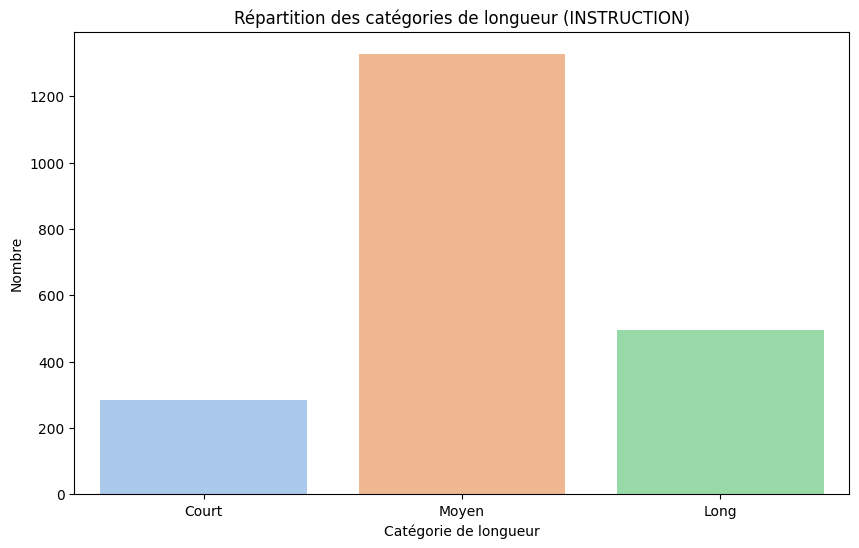

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='INSTRUCTION_category', data=train_df, palette="pastel", order=['Court', 'Moyen', 'Long'])
plt.title('Répartition des catégories de longueur (INSTRUCTION)')
plt.xlabel('Catégorie de longueur')
plt.ylabel('Nombre')
plt.show()

La majorité des instructions se trouvent dans la catégorie **Moyen** (50-150 caractères), ce qui suggère que les consignes sont généralement bien équilibrées entre brièveté et clarté. Les instructions longues (> 150 caractères) constituent une part notable, apportant probablement un contexte plus détaillé pour des réponses plus complexes. Enfin, les instructions courtes (< 50 caractères) sont les moins fréquentes, reflétant une préférence pour des consignes fournissant un minimum de contexte. Cette répartition diversifiée offre un bon équilibre pour entraîner un modèle capable de gérer différentes complexités d'instructions.

<ipython-input-252-8c1d34c3c3d3>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='RESPONSE_category', data=train_df, palette="pastel", order=['Court', 'Moyen', 'Long'])


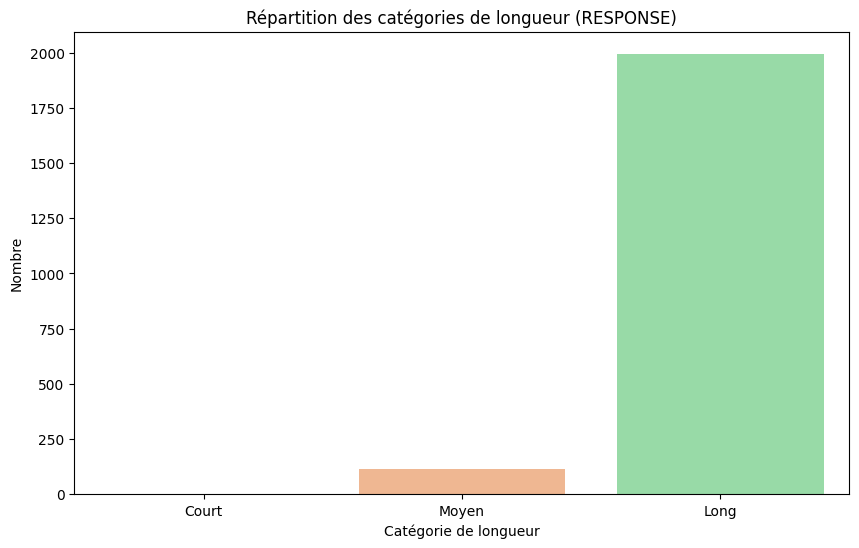

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='RESPONSE_category', data=train_df, palette="pastel", order=['Court', 'Moyen', 'Long'])
plt.title('Répartition des catégories de longueur (RESPONSE)')
plt.xlabel('Catégorie de longueur')
plt.ylabel('Nombre')
plt.show()

La majorité des réponses appartiennent à la catégorie **Long** (> 150 caractères), ce qui indique que les poèmes générés sont généralement détaillés et développés, fournissant un contenu riche en réponse aux instructions. Les réponses de longueur moyenne (50-150 caractères) sont rares, tandis que les réponses courtes (< 50 caractères) sont presque inexistantes, montrant une préférence marquée pour des réponses substantiellement élaborées. Cette répartition est cohérente avec l'objectif de générer des poèmes riches et expressifs, bien adaptés au contexte des instructions.

**Distribution des Longueurs**

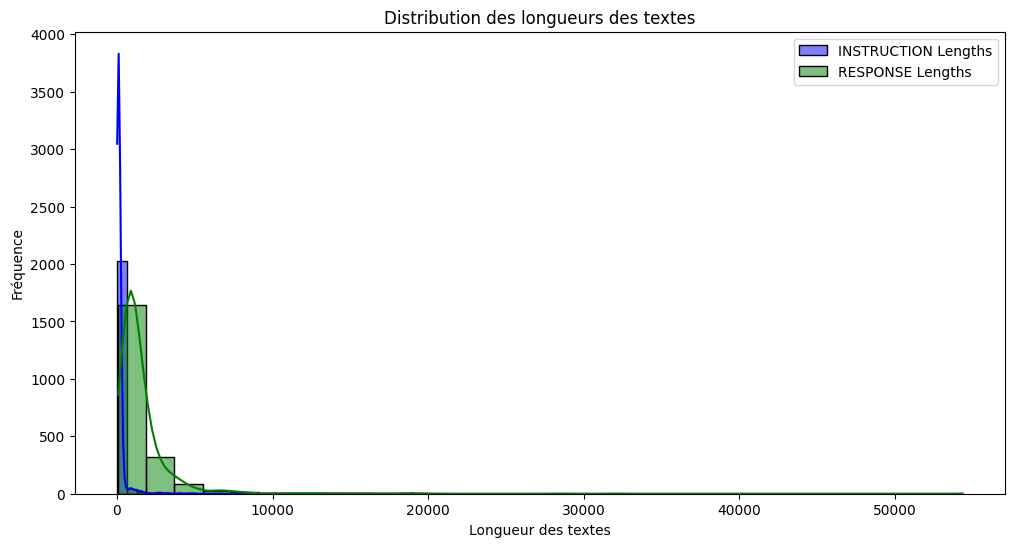

In [ ]:
# Visualisation des distributions des longueurs
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.histplot(train_df['INSTRUCTION_length'], bins=30, kde=True, label="INSTRUCTION Lengths", color='blue')
sns.histplot(train_df['RESPONSE_length'], bins=30, kde=True, label="RESPONSE Lengths", color='green')
plt.title('Distribution des longueurs des textes')
plt.xlabel('Longueur des textes')
plt.ylabel('Fréquence')
plt.legend()
plt.show()

Ce graphe montre une nette différence entre la distribution des longueurs des instructions et des réponses. Les instructions, généralement comprises entre **50 et 200 caractères**, sont relativement courtes et concentrées autour d'une moyenne basse, indiquant leur rôle de consignes claires et concises. En revanche, les réponses sont beaucoup plus longues, avec une large distribution allant jusqu'à **plus de 50 000 caractères**, reflétant la richesse et la profondeur des poèmes générés. Cette distinction est cohérente avec le besoin d'instructions simples pour produire des sorties détaillées et élaborées.

**Analyse de la diversité lexicale**

In [ ]:
import re

def calculate_lexical(column):
    # Combiner tout le texte en une seule chaîne
    all_text = ' '.join(column)

    # convertir tout en minuscules et retirer les ponctuations
    all_text_cleaned = re.sub(r'[^\w\s]', '', all_text.lower())

    # Séparer les mots
    words = all_text_cleaned.split()

    # Identifier les mots uniques
    unique_words = set(words)

    # Calculer la diversité lexicale
    return len(unique_words) / len(words) if len(words) > 0 else 0

In [ ]:
INSTRUCTION_diversity = calculate_lexical(train_df['INSTRUCTION'])
RESPONSE_diversity = calculate_lexical(train_df['RESPONSE'])

print("Diversité lexicale (INSTRUCTION): ", INSTRUCTION_diversity)
print("Diversité lexicale (RESPONSE): ", RESPONSE_diversity)

Diversité lexicale (INSTRUCTION):  0.16068857457440502
Diversité lexicale (RESPONSE):  0.08822079842286841


**1. Diversité lexicale des instructions** : **16.06%**  
   - Environ **16%** des mots dans les instructions sont uniques, ce qui montre une diversité modérée. Cela reflète la variété des consignes, avec des termes qui reviennent fréquemment pour structurer les demandes.

**2. Diversité lexicale des réponses** : **8.82%**  
   - La diversité lexicale est nettement plus faible pour les réponses, avec environ **9%** de mots uniques. Cela indique une utilisation récurrente de motifs poétiques ou stylistiques propres à la génération de poèmes.

**Corrélation entre la longueur des instructions et des poeme**

In [ ]:
length_correlation = train_df['INSTRUCTION_length'].corr(train_df['RESPONSE_length'])
print("Corrélation des longueurs: ", length_correlation)

Corrélation des longueurs:  -0.06202145606499599


La corrélation légèrement négative (**-0.06**) entre la longueur des instructions et celle des réponses indique qu'il n'existe presque aucune relation linéaire entre ces deux variables. Cela suggère que la longueur des poèmes générés ne dépend pas directement de la longueur des instructions.

**Similarité entre instructions et réponses**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Vectorisation TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(train_df['INSTRUCTION'] + train_df['RESPONSE'])

# Calcul de similarité moyenne
cosine_similarities = cosine_similarity(tfidf_matrix)
average_similarity = cosine_similarities.mean()

average_similarity

0.025763422438053032

La similarité cosinus moyenne est faible (**0.0257**), indiquant que les instructions et réponses du dataset ont un contenu lexical globalement peu similaire, ce qui reflète une bonne diversité dans les données.

In [ ]:
def classify_sentence_type(text):
    if '?' in text:
        return 'question'
    elif '!' in text:
        return 'exclamation'
    else:
        return 'neutral'

train_df['INSTRUCTION_type'] = train_df['INSTRUCTION'].apply(classify_sentence_type)
train_df['RESPONSE_type'] = train_df['RESPONSE'].apply(classify_sentence_type)

# Proportions des types
INSTRUCTION_type_distribution = train_df['INSTRUCTION_type'].value_counts(normalize=True)
RESPONSE_type_distribution = train_df['RESPONSE_type'].value_counts(normalize=True)

In [ ]:
print("Instruction Type Distribution: \n",INSTRUCTION_type_distribution)

Instruction Type Distribution: 
 INSTRUCTION_type
neutral        0.758784
question       0.238367
exclamation    0.002849
Name: proportion, dtype: float64


In [ ]:
print("Resonse Type Distribution: \n",RESPONSE_type_distribution)

Resonse Type Distribution: 
 RESPONSE_type
neutral        0.526591
question       0.337132
exclamation    0.136277
Name: proportion, dtype: float64


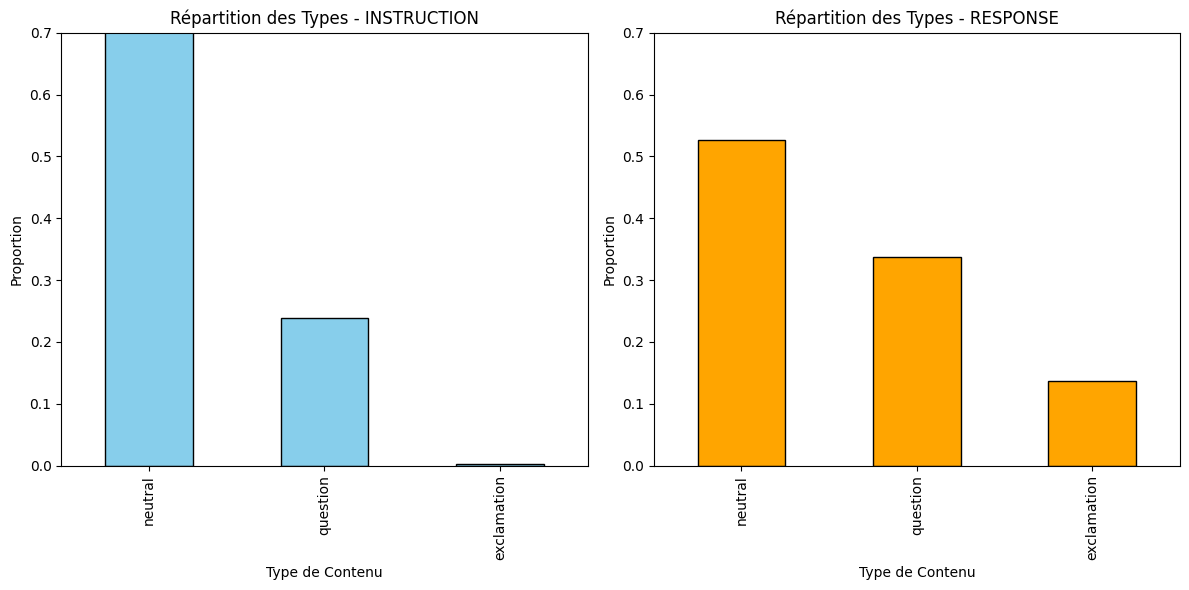

In [ ]:
# Visualisation des distributions des types
plt.figure(figsize=(12, 6))

# Distribution des types des instructions
plt.subplot(1, 2, 1)
INSTRUCTION_type_distribution.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Répartition des Types - INSTRUCTION')
plt.xlabel('Type de Contenu')
plt.ylabel('Proportion')
plt.ylim(0, 0.7)

# Distribution des types des réponse
plt.subplot(1, 2, 2)
RESPONSE_type_distribution.plot(kind='bar', color='orange', edgecolor='black')
plt.title('Répartition des Types - RESPONSE')
plt.xlabel('Type de Contenu')
plt.ylabel('Proportion')
plt.ylim(0, 0.7)

plt.tight_layout()
plt.show()

**1. Instructions (INSTRUCTION)** :
   - La majorité des instructions (**76%**) sont de type **neutre**, indiquant qu'elles sont souvent des demandes ou des consignes simples, sans question ni exclamation.
   - Les instructions de type **question** représentent environ **23%**, ce qui reflète des demandes formulées sous forme interrogative.
   - Les instructions avec des exclamations sont très rares (**0.3%**), soulignant que peu de consignes expriment un ton particulièrement emphatique.

**2. Réponses (RESPONSE)** :
   - Les réponses **neutres** restent dominantes (**52%**), mais leur proportion est réduite par rapport aux instructions.
   - Les réponses de type **question** augmentent significativement (**33%**), ce qui peut refléter un style interactif ou des réponses cherchant à engager l'utilisateur.
   - Les réponses avec des **exclamations** sont également plus fréquentes (**13%**), probablement en raison du style poétique qui favorise des expressions emphatiques.

Ce contraste montre que les réponses adoptent un style plus expressif et interactif, s'écartant des instructions qui sont principalement neutres et informatives.

#**2. Nettoyage des données**

Après toute cette exploration effectuée sur nos données (longueurs, similarités, etc.), nous pouvons affirmer que nos données sont bien nettoyées et prêtes à être utilisées pour le fine-tuning de notre modèle 'Mistral'.
C'est ce que nous allons voir dans la suite.

#**3. Préparation des données** :

Configuration de l'utilisation du GPU

In [ ]:
import torch
device_map = {"": torch.cuda.current_device()} if torch.cuda.is_available() else None

Authentification avec Hugging Face

In [ ]:
import json
config_data = json.load(open('config.json'))
HF_TOKEN = config_data['HF_TOKEN']

In [ ]:
from huggingface_hub import login
login(token=HF_TOKEN)

Chargement du modèle et du tokenizer et application de QLoRA

In [ ]:
model_name = "meta-llama/Meta-Llama-3-8B-Instruct"

In [ ]:
from transformers import BitsAndBytesConfig
import torch

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16

)

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=quantization_config,
    device_map="auto",
  )

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

model = prepare_model_for_kbit_training(model)

lora_config = LoraConfig(
    r=64,
    lora_alpha=16,
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj","gate_proj"]
)

model = get_peft_model(model, lora_config)

In [ ]:
model.print_trainable_parameters()

trainable params: 92,274,688 || all params: 8,122,535,936 || trainable%: 1.1360


Test du modèle avant le fine tuning

In [ ]:
from transformers import pipeline

messages = [
    {"role": "user", "content": "Who are you?"},
    {"role": "user", "content": "can you write poems?"},
]
pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)
pipe(messages)

Device set to use cuda:0
The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForCausalLM', 'JetMoeForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'Mamba2ForCausalLM', 'MarianFor

[{'generated_text': [{'role': 'user', 'content': 'Who are you?'},
   {'role': 'user', 'content': 'can you write poems?'},
   {'role': 'assistant',
    'content': "I'm LLaMA, an AI assistant trained by Meta AI that can understand and respond to human input in a conversational manner. I'm not a human poet, but I can certainly try to create poems for you!\n\nI can generate poems in various forms, styles, and themes. Please give me a prompt or topic, and I'll do my best to craft a poem for you. Keep in mind that AI-generated poems might not be as nuanced or emotionally resonant as those written by human poets, but I'll do my best to create something enjoyable and meaningful.\n\nWould you like me to write a poem on a specific topic or theme? Or would you like me to come up with something entirely new?"}]}]

preparer les entre et les sorti avec la prompte :

In [ ]:
Role = "You are a poet who writes in a lyrical and evocative style"
Task = "Write a poem based on the user `INSTRUCTION`"

In [ ]:
print(train_df['INSTRUCTION'][7187])

Make a poem with themes of Social Commentaries,Cities & Urban Life.Generate a poem with the following themes: Social Commentaries,Cities & Urban Life.


In [ ]:
input = f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\n{Role}<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nINSTRUCTION: {train_df['INSTRUCTION'][7187]}\nTask: {Task}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n"""

In [ ]:
tokenized_input = tokenizer(input, return_tensors="pt", padding=True, truncation=True, max_length=300)

In [ ]:
model_answer = model.generate(
    input_ids = tokenized_input.input_ids.to(model.device),
    attention_mask = tokenized_input.attention_mask.to(model.device),
    max_new_tokens=350,
    pad_token_id=tokenizer.eos_token_id,
    do_sample=True,
    top_k=10,
    num_return_sequences=1,
    eos_token_id=tokenizer.eos_token_id,
    )

In [ ]:
decoded_answer = tokenizer.decode(model_answer[0], skip_special_tokens=True)
print(decoded_answer)

system

You are a poet who writes in a lyrical and evocative styleuser

INSTRUCTION: Make a poem with themes of Social Commentaries,Cities & Urban Life.Generate a poem with the following themes: Social Commentaries,Cities & Urban Life.
Task: Write a poem based on this INSTRUCTIONassistant

In concrete canyons, where steel and stone entwine,
A city's pulse beats strong, a rhythm divine.
A tapestry of lives, a kaleidoscope of strife,
A metropolis alive, where dreams and despair rife.

The skyscrapers pierce the sky, a forest of glass and steel,
A monument to progress, a testament to our zeal.
But amidst the grandeur, the homeless huddle and hide,
Their stories untold, their struggles to survive, a city's pride.

The streets are paved with gold, or so it would seem,
A promise of prosperity, a dream of success, a theme.
But amidst the glitz and glamour, the have-nots roam,
Their voices silenced, their stories left to atone.

The city's heartbeat quickens, a symphony of sound,
A cacophony o

In [ ]:
for index, row in train_df.iterrows():
  i = index
  train_df.loc[index, 'input_text'] = f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\n{Role} \nTask: {Task}<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nINSTRUCTION: {row['INSTRUCTION']}\n<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n"""
  train_df.loc[index, 'output_text'] = f"""<|begin_of_text|><|start_header_id|>assistant<|end_header_id|>\n\nPoem: {row['RESPONSE']}"""

In [ ]:
for index, row in test_df.iterrows():
  i = index
  test_df.loc[index, 'input_text'] = f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\n{Role} \nTask: {Task}<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nINSTRUCTION: {row['INSTRUCTION']}\n<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n"""
  test_df.loc[index, 'output_text'] = f"""<|begin_of_text|><|start_header_id|>assistant<|end_header_id|>\n\nPoem: {row['RESPONSE']}"""

In [ ]:
for index, row in validation_df.iterrows():
  i = index
  validation_df.loc[index, 'input_text'] = f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\n{Role} \nTask: {Task}<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nINSTRUCTION: {row['INSTRUCTION']}\n<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n"""
  validation_df.loc[index, 'output_text'] = f"""<|begin_of_text|><|start_header_id|>assistant<|end_header_id|>\n\nPoem: {row['RESPONSE']}"""

In [ ]:
new_train_df = train_df[['input_text', 'output_text']]

In [ ]:
new_test_df = test_df[['input_text', 'output_text']]

In [ ]:
print(new_test_df['input_text'][5901])

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

You are a poet who writes in a lyrical and evocative style 
Task: Write a poem based on the user `INSTRUCTION`<|eot_id|><|start_header_id|>user<|end_header_id|>

INSTRUCTION: Make a poem with themes of Living,Love,Relationships.Generate a poem with the following themes: Living,Love,Relationships.
<|eot_id|><|start_header_id|>assistant<|end_header_id|>




In [ ]:
new_validation_df = validation_df[['input_text', 'output_text']]

Séparation des données en ensembles d'entrée `X` et de sortie `y` pour l'entraînement, la validation et les tests

In [ ]:
X_train_data = new_train_df['input_text'].values
X_validation_data = new_validation_df['input_text'].values
X_test_data = new_test_df['input_text'].values

y_train_data = new_train_df['output_text'].values
y_validation_data = new_validation_df['output_text'].values
y_test_data = new_test_df['output_text'].values

In [ ]:
X_train_data.shape, X_validation_data.shape, X_test_data.shape

((2106,), (139,), (138,))

Tokenisation des données d'entrée (instructions) et de sortie (poemes) pour l'entraînement, la validation et les tests

In [ ]:
# Tokenisation des entrées
X_train_tokens = tokenizer(X_train_data.tolist(), padding=True, truncation=True, return_tensors="pt", max_length=250)
X_validation_tokens = tokenizer(X_validation_data.tolist(), padding=True, truncation=True, return_tensors="pt", max_length=250)
X_test_tokens = tokenizer(X_test_data.tolist(), padding=True, truncation=True, return_tensors="pt", max_length=250)

# Tokenisation des sortie
y_train_tokens = tokenizer(y_train_data.tolist(), padding=True, truncation=True, return_tensors="pt", max_length=250)
y_validation_tokens = tokenizer(y_validation_data.tolist(), padding=True, truncation=True, return_tensors="pt", max_length=250)
y_test_tokens = tokenizer(y_test_data.tolist(), padding=True, truncation=True, return_tensors="pt", max_length=250)


Adaptation des datasets d'entraînement, de validation et de test pour le fine-tuning

In [ ]:
from torch.utils.data import DataLoader, Dataset

class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.encodings.input_ids)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        label = self.labels.input_ids[idx]
        item['labels'] = torch.tensor(label)
        return item

train_dataset = CustomDataset(X_train_tokens, y_train_tokens)
validation_dataset = CustomDataset(X_validation_tokens, y_validation_tokens)
test_dataset = CustomDataset(X_test_tokens, y_test_tokens)

#**4. Fine-tuning du modèle**

Gestion et optimisation de la mémoire GPU

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
!nvidia-smi

Sat Jan 25 22:04:57 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0              51W / 400W |   9629MiB / 40960MiB |     12%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
!kill -9 <pid>

/bin/bash: -c: line 1: syntax error near unexpected token `newline'
/bin/bash: -c: line 1: `kill -9 <pid>'


In [ ]:
%env PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

env: PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True


Initialisation de l'accélérateur

In [ ]:
import os
from accelerate import Accelerator
#Configuration des variables d'environnement pour optimiser l'efficacité GPU
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "dryrun"

# Initialisation de l'accélérateur
accelerator = Accelerator(mixed_precision="fp16")

Initialisation de DataCollator

In [ ]:
from transformers import DataCollatorForLanguageModeling
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,
)

Définition des arguments pour l'entraînement du modèle

In [ ]:
from transformers import TrainingArguments
from trl import SFTTrainer

output_dir = "data/mistral-7b-sft-lora_v0.1"

# Arguments d'entraînement
training_args = TrainingArguments(
    output_dir=output_dir,
    evaluation_strategy="epoch",
    learning_rate=1e-4,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    num_train_epochs=3,
    # gradient_accumulation_steps=16,
    fp16=True,
    save_steps=2000,
    save_total_limit=2,
    logging_dir="./logs",
    logging_steps=10,
    gradient_checkpointing=True,
    optim="adamw_torch",
    report_to="none",
    eval_accumulation_steps=2
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Fonction de calcul des métriques d'évaluation du modèle

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

def compute_metrics(eval_pred):
    from rouge_score import rouge_scorer

    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)

    # Convertir les prédictions et les labels en texte
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)

    # Filtrer les labels pour exclure les IDs hors du vocabulaire
    filtered_labels = [
        [token_id for token_id in l if 0 <= token_id < tokenizer.vocab_size]
        for l in labels
    ]
    decoded_labels = tokenizer.batch_decode(filtered_labels, skip_special_tokens=True)

    # Calculer les scores ROUGE
    scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)
    rouge_scores = [scorer.score(pred, label) for pred, label in zip(decoded_preds, decoded_labels)]

    rouge1 = sum(score["rouge1"].fmeasure for score in rouge_scores) / len(rouge_scores)
    rouge2 = sum(score["rouge2"].fmeasure for score in rouge_scores) / len(rouge_scores)
    rougeL = sum(score["rougeL"].fmeasure for score in rouge_scores) / len(rouge_scores)

    # Calculer la similarité cosinus
    vectorizer = TfidfVectorizer().fit(decoded_preds + decoded_labels)
    tfidf_preds = vectorizer.transform(decoded_preds)
    tfidf_labels = vectorizer.transform(decoded_labels)
    similarities = [cosine_similarity(tfidf_preds[i], tfidf_labels[i])[0][0] for i in range(len(decoded_preds))]
    avg_similarity = sum(similarities) / len(similarities)

    return {
        "rouge1": rouge1,
        "rouge2": rouge2,
        "rougeL": rougeL,
        "similarity": avg_similarity,
    }

Initialisation du Trainer pour le Fine-Tuning

In [ ]:
# Initialiser le trainer
trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

<ipython-input-141-ac87e57b3bf7>:2: FutureWarning: `tokenizer` is deprecated and removed starting from version 0.16.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  trainer = SFTTrainer(
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Lancement de l'entraînement du modèle

In [ ]:
trainer.train()

<ipython-input-132-634a03ef4747>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-132-634a03ef4747>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(label)
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Similarity
1,0.204000,0.399935,0.789387,0.657639,0.780599,0.622120
2,0.215500,0.395674,0.788671,0.657508,0.779749,0.619983
3,0.201400,0.398739,0.789574,0.659528,0.780275,0.623967


<ipython-input-132-634a03ef4747>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-132-634a03ef4747>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(label)
<ipython-input-132-634a03ef4747>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-132-634a03ef4747>:14: UserWarning: To copy construct from a tensor, it is recommended to us

TrainOutput(global_step=6318, training_loss=0.34696902095535653, metrics={'train_runtime': 3847.3621, 'train_samples_per_second': 1.642, 'train_steps_per_second': 1.642, 'total_flos': 7.199865833472e+16, 'train_loss': 0.34696902095535653, 'epoch': 3.0})

### **1. Training Loss**
- **Époque 1 : 0.204000**  
- **Époque 2 : 0.215500**  
- **Époque 3 : 0.201400**  
- **Observation** : La perte d'entraînement montre une légère augmentation à l'époque 2, suivie d'une baisse à l'époque 3. Cela pourrait indiquer une légère variation due à des mécanismes comme la régularisation ou à une répartition des batchs. La diminution finale de la perte suggère que le modèle continue d'apprendre et de s'ajuster au dataset, bien que les variations globales soient faibles.


### **2. Validation Loss**
- **Époque 1 : 0.399935**  
- **Époque 2 : 0.395674**  
- **Époque 3 : 0.398739**  
- **Observation** : La perte de validation diminue légèrement à l'époque 2, ce qui indique une meilleure généralisation du modèle à ce stade. Cependant, une augmentation marginale à l'époque 3 pourrait refléter un début de suradaptation (overfitting) ou des variations liées à la complexité des données de validation. La stabilité des pertes globales suggère que le modèle converge bien.


### **3. Scores ROUGE**
#### **ROUGE-1** (unigrammes) :
- **Époque 1 : 0.789387**  
- **Époque 2 : 0.788671**  
- **Époque 3 : 0.789574**  
- **Analyse** : Les scores ROUGE-1 restent globalement stables avec des variations mineures entre les époques. Cela montre que le modèle maintient sa capacité à produire des mots pertinents et alignés avec le texte cible.

#### **ROUGE-2** (bigrammes) :
- **Époque 1 : 0.657639**  
- **Époque 2 : 0.657508**  
- **Époque 3 : 0.659528**  
- **Analyse** : Une amélioration légère mais notable à l'époque 3 suggère que le modèle apprend à mieux construire des séquences locales cohérentes, ce qui renforce la fluidité des poèmes générés.

#### **ROUGE-L** (longest common subsequence) :
- **Époque 1 : 0.780599**  
- **Époque 2 : 0.779749**  
- **Époque 3 : 0.780275**  
- **Analyse** : Les scores ROUGE-L restent pratiquement constants, indiquant que la structure globale des phrases générées est alignée avec celle des textes cibles. Cela montre que le modèle conserve une bonne cohérence structurelle.


### **4. Similitude Cosinus**
- **Époque 1 : 0.622120**  
- **Époque 2 : 0.619983**  
- **Époque 3 : 0.623967**  
- **Observation** : Les scores de similarité cosinus augmentent légèrement entre les époques 2 et 3. Cette progression montre que les poèmes générés deviennent sémantiquement plus proches des textes cibles au fil des itérations. La stabilité globale des scores suggère que le modèle capture bien les concepts sous-jacents.


### **Synthèse globale**
- Le modèle montre une **bonne stabilité globale** avec des pertes (training et validation) et des métriques (ROUGE, similarité cosinus) relativement stables.
- **Légères variations** dans les scores entre les époques, mais elles indiquent une convergence, sans signe significatif de suradaptation.
- Le score ROUGE-2 et la similarité cosinus à l'époque 3 montrent que le modèle continue de s'améliorer en termes de cohérence et de proximité sémantique, ce qui est prometteur pour la qualité des poèmes générés.

Évaluation finale du modèle sur l'ensemble de test

In [ ]:
results = trainer.evaluate(test_dataset)

<ipython-input-132-634a03ef4747>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-132-634a03ef4747>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(label)


In [ ]:
print("Résultats de l'évaluation :\n", results)

Résultats de l'évaluation :
 {'eval_loss': 0.44001394510269165, 'eval_rouge1': 0.7818583857660346, 'eval_rouge2': 0.6448093144466653, 'eval_rougeL': 0.7700093236608381, 'eval_similarity': 0.6079155291852115, 'eval_runtime': 250.9057, 'eval_samples_per_second': 0.55, 'eval_steps_per_second': 0.55, 'epoch': 3.0}


In [ ]:
results

{'eval_loss': 0.44001394510269165,
 'eval_rouge1': 0.7818583857660346,
 'eval_rouge2': 0.6448093144466653,
 'eval_rougeL': 0.7700093236608381,
 'eval_similarity': 0.6079155291852115,
 'eval_runtime': 250.9057,
 'eval_samples_per_second': 0.55,
 'eval_steps_per_second': 0.55,
 'epoch': 3.0}

- Le modèle affiche des performances solides sur les données de test, avec des scores ROUGE et de similarité cohérents avec les résultats précédents. Cela suggère qu'il a bien appris à générer des poèmes alignés sémantiquement et structurellement avec les textes cibles.
- Les légères divergences entre les scores sur validation et test (notamment sur la similarité) pourraient indiquer des différences dans la distribution des données, mais elles restent dans une marge acceptable.

# **5. Évaluation des performances**

Connexion à Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Sauvegarde et exportation du modèle

In [ ]:
trainer.save_model("/content/drive/MyDrive/projet_Gen_ia/llma3-8b_on_instruction_poems")

Chargement du modèle finetuner depuis Google Drive

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import torch

model_name = "/content/drive/MyDrive/projet_Gen_ia/llma3-8b_on_instruction_poems"
tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Attribution du modèle à l'appareil approprié (GPU ou CPU)

In [ ]:
device_map = "cuda" if torch.cuda.is_available() else "cpu"
if torch.cuda.is_available():
    model = model.to(device_map)
    print("model is in the device")
else:
    model = model.to("cpu")

model is in the device


In [ ]:
input = validation_df['input_text'][260]
print("input : ", input)
print("#"*30)
output =validation_df['output_text'][260]
tokenized_inpout = tokenizer(input, return_tensors="pt", max_length=250, padding=True, truncation=True)
input_ids = tokenized_inpout["input_ids"]
attention_mask = tokenized_inpout["attention_mask"]
response = model.generate(
    input_ids=input_ids.to(model.device),
    attention_mask=attention_mask.to(model.device),
    max_new_tokens=400,
    # temperature=0.6,
    # top_k=80,
    pad_token_id=tokenizer.eos_token_id
)
response_text = tokenizer.decode(response[0], skip_special_tokens=True)
predicted_poeme = response_text
print("predicted_poeme :\n ", predicted_poeme)
print("#"*30)
ture_poeme = output
print("ture_poeme : ", ture_poeme)

input :  <|begin_of_text|><|start_header_id|>system<|end_header_id|>

You are a poet who writes in a lyrical and evocative style<|eot_id|><|start_header_id|>user<|end_header_id|>

INSTRUCTION: Can you write a poem? Make it about Living,Death,Time & Brevity,Philosophy.
Task: Write a poem based on this INSTRUCTION<|eot_id|><|start_header_id|>assistant<|end_header_id|>


##############################
predicted_poeme :
  system

You are a poet who writes in a lyrical and evocative styleuser

INSTRUCTION: Can you write a poem? Make it about Living,Death,Time & Brevity,Philosophy.
Task: Write a poem based on this INSTRUCTIONassistant

Here is a poem based on this INSTRUCTION:

I. The Socrates of the Piazza

The old man from the piazza is back, and he’s talking again about the meaning of life and death. He says the Greeks were right: life is a series of moments, each one like a drop of water in the ocean. When the drop hits the surface, it disappears, and the ocean remains, unchanged.

I say

In [ ]:
import re

# Utiliser une expression régulière pour extraire après "assistant"
def extract_response(predicted_poem):
  # Utiliser une expression régulière pour extraire après "assistant"
  match = re.search(r"assistant\s*\n\n(.*)", predicted_poem, re.DOTALL)
  if match:
      prediction_only = match.group(1).strip()
  else:
      prediction_only = predicted_poem.strip()  # Si aucun match, tout le texte

  return prediction_only

In [ ]:
print(extract_response(predicted_poeme))

Here is a poem based on this INSTRUCTION:

I. The Socrates of the Piazza

The old man from the piazza is back, and he’s talking again about the meaning of life and death. He says the Greeks were right: life is a series of moments, each one like a drop of water in the ocean. When the drop hits the surface, it disappears, and the ocean remains, unchanged.

I say to him, “But what about the moments that make us who we are? Don’t they count for something?”

The old man says, “Of course they do, but they are just moments. They are like the leaves of a tree, each one unique, but they all fall off eventually.

I think of my father, who died when I was a boy. I remember the sound of his laughter, the smell of his pipe, the way he used to read to me from the Iliad. I think of my mother, who died when I was older. I remember the way she used to make me breakfast in bed, the way she used to sit with me and listen while I read my poetry.

The old man says, “These moments are like the moments of a 

Extraire la réponse générée par le model

In [ ]:
import re

# Expression régulière pour extraire le contenu entre "Poem:" et "Source:"
def extract_true_response(ture_poeme):
  match = re.search(r"Poem:(.*)Source:", ture_poeme, re.DOTALL)
  if match:
      extracted_poem = match.group(1).strip()
  else:
      extracted_poem = ture_poeme.strip()
  return extracted_poem

In [ ]:
print(extract_true_response(ture_poeme))

Of course! It's called "Immortality Ode": 
Miss Bliss, once I thought I was endless

since father was perpetual in his grade school

of seedlings in cups, the overly loved pets, and recess

while mother was the lipsticked dancing girl

on the Steel Pier who would outstep Hitler.

I was insufferable when I rolled

the Volkswagen bus two times and lived

with the snow chains like costumed jewels

slung over me and the spare rolled

away as in a folktale.

The pact I made in the spinning instant

said in my language of American

boy, Put up or shut up, to God,

the State Trooper who was kind

and spoke of service and punishment

and giving yourself away.

Now, I’m alive through the agency

of iron and contract work and appeals

to the fallen—angel and dusk—

but wet-winged and still without you,

Miss Bliss, who took me inside

where there was an ocean

before which we were children.

That calm, that fear,

that witness of the two-thirds

of everything else.


Fonction pour générer des prédictions et sauvegarder les résultats

In [ ]:
def generate_poeme(dataset, output_file):
    results = []
    j = 0
    for index, row in dataset.iterrows():
        i = index
        prompt = dataset['input_text'][i]
        input = prompt
        output = dataset['output_text'][i]
        tokenized_inpout = tokenizer(input, return_tensors="pt", max_length=512, padding=True, truncation=True)
        input_ids = tokenized_inpout["input_ids"]
        attention_mask = tokenized_inpout["attention_mask"]
        response = model.generate(
            input_ids=input_ids.to(model.device),
            attention_mask=attention_mask.to(model.device),
            max_new_tokens=300,
            temperature=0.7,
            # top_k=60,
            # do_sample=True,
            top_k=80,
            num_return_sequences=1,
            pad_token_id=tokenizer.eos_token_id,
            eos_token_id=tokenizer.eos_token_id
        )
        response_text = tokenizer.decode(response[0], speak_spicial_tokes=True)
        predicted_poeme = extract_response(response_text)
        ture_poeme = extract_true_response(output)
        results.append({
          "Index": index,
          "Entred_prompt": input,
          "Model_response": response_text,
          "Ture_poeme": ture_poeme,
          "Predicted_poeme": predicted_poeme,
        })
        # print(i, "Entred_prompt : ", input, "ture_poeme : ", output)
        print("#"*100)
        j += 1
        print("j : ", j)
        print("predicted_poeme : ", predicted_poeme)
        print("#"*100)
        # print("response_text  : ", response_text)
    df_results = pd.DataFrame(results)
    df_results.to_csv(output_file, index=False)
    print(f"Les prédictions ont été enregistrées dans {output_file}")

Nous allons tester sur notre jeu de données de test:

In [ ]:
new_test_df.shape

(138, 2)

Génération des prédictions :

In [ ]:
generate_poeme(new_test_df, "/content/drive/MyDrive/projet_Gen_ia/new_test_df.csv")

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Task: Write a poem based on this INSTRUCTION
Note: I've generated a poem with the given themes. I hope you like it! Let me know if you want me to make any changes.
Task: Write a poem based on this INSTRUCTION
I'd be happy to make changes to the poem. What would you like me to change?<|eot_id|>
####################################################################################################
####################################################################################################
j :  43
predicted_poeme :  <|begin_of_text|><|begin_of_text|><|start_header_id|>system<|end_header_id|>

You are a poet who writes in a lyrical and evocative style<|eot_id|><|start_header_id|>user<|end_header_id|>

INSTRUCTION: Make a poem with themes of Relationships,Family & Ancestors,Nature,Animals,Trees & Flowers,Weather,Social Commentaries,Gender & Sexuality,History & Politics.Generate a poem with the following theme

Chargement des prédictions générées depuis les fichiers sauvegardés

In [ ]:
testdata = pd.read_csv("/content/drive/MyDrive/projet_Gen_ia/new_test_df.csv")

In [ ]:
testdata

,Index,Entred_prompt,Model_response,Ture_poeme,Predicted_poeme
0,12086,<|begin_of_text|><|start_header_id|>system<|en...,<|begin_of_text|><|begin_of_text|><|start_head...,"I've written a poem for you about Activities,T...",<|begin_of_text|><|begin_of_text|><|start_head...
1,13246,<|begin_of_text|><|start_header_id|>system<|en...,<|begin_of_text|><|begin_of_text|><|start_head...,"How about calling it ""The Spider""?",<|begin_of_text|><|begin_of_text|><|start_head...
2,5901,<|begin_of_text|><|start_header_id|>system<|en...,<|begin_of_text|><|begin_of_text|><|start_head...,"Of course! It's called ""The Window"": \nyou are...",<|begin_of_text|><|begin_of_text|><|start_head...
3,5420,<|begin_of_text|><|start_header_id|>system<|en...,<|begin_of_text|><|begin_of_text|><|start_head...,"I've written a poem for you about Living,Death...",<|begin_of_text|><|begin_of_text|><|start_head...
4,3493,<|begin_of_text|><|start_header_id|>system<|en...,<|begin_of_text|><|begin_of_text|><|start_head...,"I've written a poem for you about Love,Break-u...",<|begin_of_text|><|begin_of_text|><|start_head...
...,...,...,...,...,...
133,7126,<|begin_of_text|><|start_header_id|>system<|en...,<|begin_of_text|><|begin_of_text|><|start_head...,"Okay, a poem about Living,Death,Sorrow & Griev...",<|begin_of_text|><|begin_of_text|><|start_head...
134,2875,<|begin_of_text|><|start_header_id|>system<|en...,<|begin_of_text|><|begin_of_text|><|start_head...,"It's called ""Family Reunion"": \nRay’s third ne...",<|begin_of_text|><|begin_of_text|><|start_head...
135,12182,<|begin_of_text|><|start_header_id|>system<|en...,<|begin_of_text|><|begin_of_text|><|start_head...,"Here's your poem about Arts & Sciences,Reading...",<|begin_of_text|><|begin_of_text|><|start_head...
136,5655,<|begin_of_text|><|start_header_id|>system<|en...,<|begin_of_text|><|begin_of_text|><|start_head...,"It's called ""Song for Pythagoras"": \nWhite coa...",<|begin_of_text|><|begin_of_text|><|start_head...


###**Évaluation des prédictions générées**

Dans cette section, nous évaluons les poèmes générés par le modèle en utilisant des métriques telles que **ROUGE** et la **similarité cosinus**. Cette évaluation compare les poèmes générés avec les véritables poèmes présents dans notre dataset, permettant d'analyser leur cohérence, leur pertinence, et leur fidélité aux instructions données. Le calcul comprend :

- **ROUGE-1, ROUGE-2, ROUGE-L** : Mesurent la précision des prédictions en termes de correspondance lexicale avec les poèmes de référence.
- **Similarité cosinus** : Évalue la proximité sémantique entre les poèmes générés et les poèmes de référence, tout en tenant compte des nuances thématiques.

In [ ]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.4 MB/s eta 0:00:00


In [ ]:
!pip install rouge-score

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
import pandas as pd

def evaluate_generated_poeme(test_data_path):
    # Charger les données générées
    test_data = pd.read_csv(test_data_path)

    # Vérifier si les colonnes nécessaires sont présentes
    required_columns = ["Ture_poeme", "Predicted_poeme"]
    for column in required_columns:
        if column not in test_data.columns:
            raise ValueError(f"La colonne '{column}' est manquante !!!")

    # Récupérer les vraies poemes et générées et remplacer les NaN par des chaînes vides
    Ture_poeme = test_data["Ture_poeme"].fillna("")
    Predicted_poeme = test_data["Predicted_poeme"].fillna("")

    # Initialiser le calculateur ROUGE
    scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)
    rouge_scores = [scorer.score(pred, label) for pred, label in zip(Predicted_poeme, Ture_poeme)]

    # Calculer les scores moyens ROUGE
    rouge1 = sum(score["rouge1"].fmeasure for score in rouge_scores) / len(rouge_scores)
    rouge2 = sum(score["rouge2"].fmeasure for score in rouge_scores) / len(rouge_scores)
    rougeL = sum(score["rougeL"].fmeasure for score in rouge_scores) / len(rouge_scores)

    # Calculer la similarité cosinus
    vectorizer = TfidfVectorizer().fit(Predicted_poeme + Ture_poeme)
    tfidf_preds = vectorizer.transform(Predicted_poeme)
    tfidf_labels = vectorizer.transform(Ture_poeme)
    similarities = [
        cosine_similarity(tfidf_preds[i], tfidf_labels[i])[0][0] for i in range(len(Predicted_poeme))
    ]
    avg_similarity = sum(similarities) / len(similarities)

    decoded_preds = Predicted_poeme.tolist()
    decoded_labels = Ture_poeme.tolist()

    # Calculer le score BLEU
    smoothing_function = SmoothingFunction().method1  # Utilise une méthode pour éviter les problèmes avec des petits n-grammes
    bleu_scores = [
        sentence_bleu([label.split()], pred.split(), smoothing_function=smoothing_function)
        for pred, label in zip(decoded_preds, decoded_labels)
    ]
    avg_bleu = sum(bleu_scores) / len(bleu_scores)

    # Retourner les métriques
    return {
        "rouge1": rouge1,
        "rouge2": rouge2,
        "rougeL": rougeL,
        "bleu": avg_bleu,
        "similarity": avg_similarity,
    }

In [ ]:
# Chemin de notre testdataset.csv
test_data_path = "/content/drive/MyDrive/projet_Gen_ia/new_test_df.csv"

# évaluation
metrics = evaluate_generated_poeme(test_data_path)

# Afficher les résultats
print("Résultats de l'évaluation :")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

Résultats de l'évaluation :
rouge1: 0.1531
rouge2: 0.0290
rougeL: 0.0970
bleu: 0.0138
similarity: 0.1499


**Interprétation des résultats :**

Les résultats montrent que le modèle produit des poèmes qui ont une faible correspondance lexicale et sémantique avec les poèmes de référence, comme l'indiquent les scores ROUGE et de similarité cosinus :

**1. Scores ROUGE** :
- **ROUGE-1 : 0.1531**  
  Ce score mesure la correspondance des mots individuels (unigrammes) entre les poèmes générés et les poèmes de référence. Le score est faible, indiquant que les mots exacts des poèmes de référence sont rarement repris dans les prédictions.

- **ROUGE-2 : 0.0290**  
  Ce score mesure la correspondance des bigrammes (paires de mots). Il est encore plus faible, ce qui suggère que les relations immédiates entre les mots ne sont pas bien capturées par le modèle.

- **ROUGE-L : 0.0970**  
  Ce score reflète la plus longue sous-séquence commune entre les poèmes générés et les poèmes de référence. La faible valeur indique que la structure globale des poèmes générés diverge significativement des poèmes de référence.
-**BLUE : 0.0138**
  Ce score indique une faible similarité entre les poèmes générés et les références. Cela signifie que le modèle a du mal à reproduire les structures exactes des poèmes de référence. Ce résultat peut être dû à un vocabulaire différent, une formulation alternative ou une créativité excessive du modèle.

**2. Similarité cosinus : 0.14**
- Ce score mesure la proximité sémantique entre les poèmes générés et les poèmes de référence. La valeur est également faible, ce qui signifie que, même sur le plan thématique ou conceptuel, les poèmes générés s'éloignent des intentions originales des instructions.

### **Visualisations des resultats :**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Charger les données
test_data = pd.read_csv(test_data_path)

# Graphique à barres des scores ROUGE
def plot_rouge_scores(metrics):
    rouge_data = {
        "ROUGE-1": metrics["rouge1"],
        "ROUGE-2": metrics["rouge2"],
        "ROUGE-L": metrics["rougeL"],
    }
    plt.figure(figsize=(8, 6))
    sns.barplot(x=list(rouge_data.keys()), y=list(rouge_data.values()), palette="Blues_d")
    plt.title("Scores ROUGE moyens")
    plt.xlabel("Type de ROUGE")
    plt.ylabel("Score")
    plt.ylim(0, 1)
    plt.show()

Visualisation des scores ROUGE


<ipython-input-286-d88c128bd48f>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(rouge_data.keys()), y=list(rouge_data.values()), palette="Blues_d")


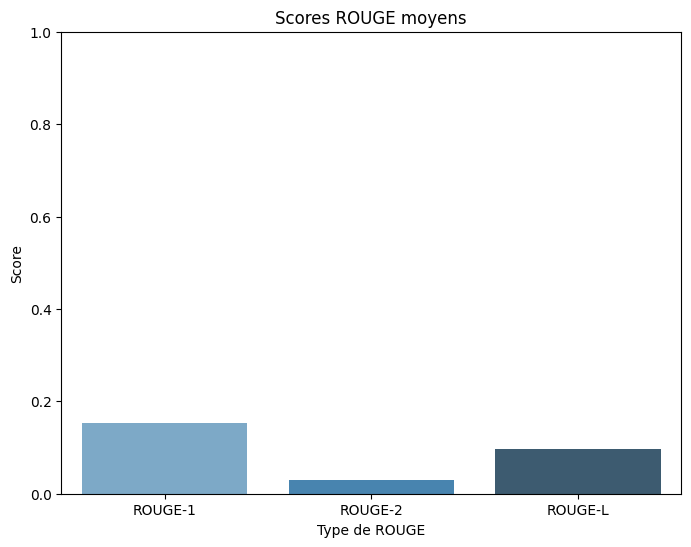

In [ ]:
# Visualiser les résultats
print("Visualisation des scores ROUGE")
plot_rouge_scores(metrics)

Ces résultats soulignent une compréhension insuffisante des instructions et des poèmes cibles, mettant en évidence la nécessité d'améliorer le fine-tuning du modèle ou d'enrichir la qualité des données d'entraînement.

**Distribution des similarités cosinus**

In [ ]:
def plot_cosine_similarity_distribution(similarities):
    plt.figure(figsize=(8, 6))
    sns.histplot(similarities, bins=30, kde=True, color="green")
    plt.title("Distribution des similarités cosinus")
    plt.xlabel("Similarité cosinus")
    plt.ylabel("Fréquence")
    plt.xlim(0, 1)
    plt.show()

Visualisation des similarités cosinus


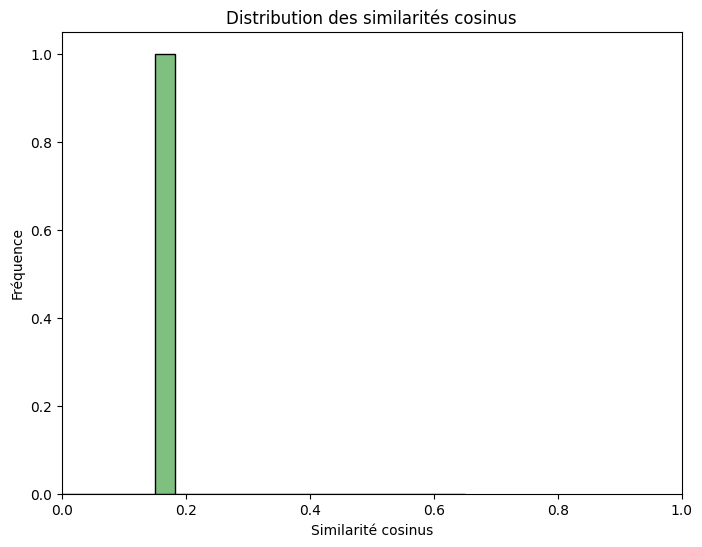

In [ ]:
print("Visualisation des similarités cosinus")
cosine_similarities = metrics["similarity"]
plot_cosine_similarity_distribution([cosine_similarities])

La distribution des similarités cosinus montre une concentration des valeurs très proches de **0**, indiquant que les poèmes générés par le modèle ont une faible proximité sémantique avec les poèmes de référence. Cela reflète un décalage significatif entre le contenu attendu et les réponses produites par le modèle. Bien que notre objectif principal soit de développer un modèle capable de générer des poèmes cohérents et pertinents qui répondent parfaitement aux instructions, même s'ils ne sont pas identiques à ceux du dataset, les résultats obtenus montrent que les poèmes générés par le modèle manquent de cohérence et de qualité globale. Cela souligne la nécessité d'améliorer le fine-tuning du modèle ou de retravailler l'interprétation des instructions.

**Comparaison des longueurs des textes générés et des vérités de référence**

In [ ]:
def plot_length_comparison(test_data):
    test_data["True_poeme_length"] = test_data["Ture_poeme"].fillna("").apply(len)
    test_data["Predicted_poeme_length"] = test_data["Predicted_poeme"].fillna("").apply(len)

    plt.figure(figsize=(8, 6))
    sns.histplot(test_data["True_poeme_length"], bins=30, color="blue", label="Longueur des poemes vraies", kde=True)
    sns.histplot(test_data["Predicted_poeme_length"], bins=30, color="orange", label="Longueur des poemes générées", kde=True)
    plt.title("Distribution des longueurs des poemes")
    plt.xlabel("Longueur des poemes")
    plt.ylabel("Fréquence")
    plt.legend()
    plt.show()

Comparaison des longueurs des poemes


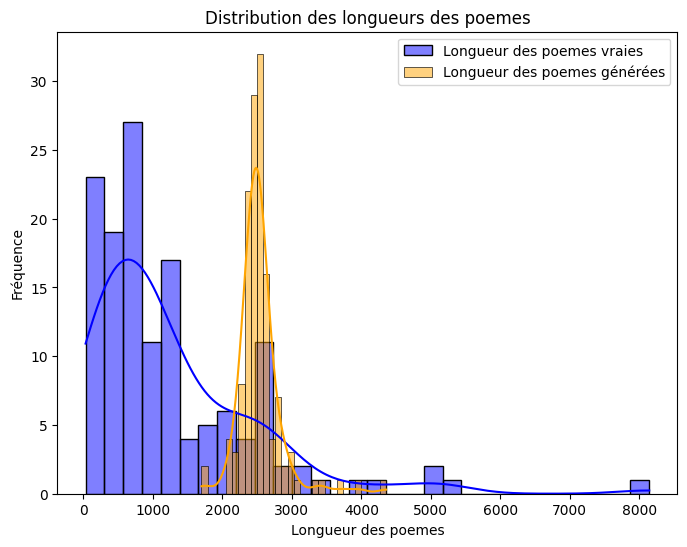

In [ ]:
print("Comparaison des longueurs des poemes")
plot_length_comparison(testdata)

Le graphique montre une différence notable entre les longueurs des poèmes générés et des poèmes de référence. Les poèmes générés sont généralement beaucoup plus courts et concentrés autour de faibles longueurs, tandis que les poèmes de référence ont une répartition plus large et incluent des textes significativement plus longs. Cela indique que le modèle a tendance à produire des réponses brèves et manque de profondeur ou de complexité comparée aux poèmes attendus.

# Tester le model sur un autre dataset `PoetryFoundationData.csv`

In [ ]:
import pandas as pd
PFD = pd.read_csv("PoetryFoundationData.csv")

In [ ]:
PFD.head()

,Unnamed: 0,Title,Poem,Poet,Tags
0,0,\r\r\n Objects Used to Prop...,"\r\r\nDog bone, stapler,\r\r\ncribbage board, ...",Michelle Menting,NaN
1,1,\r\r\n The New Church\r\r\n...,"\r\r\nThe old cupola glinted above the clouds,...",Lucia Cherciu,NaN
2,2,\r\r\n Look for Me\r\r\n ...,\r\r\nLook for me under the hood\r\r\nof that ...,Ted Kooser,NaN
3,3,\r\r\n Wild Life\r\r\n ...,"\r\r\nBehind the silo, the Mother Rabbit\r\r\n...",Grace Cavalieri,NaN
4,4,\r\r\n Umbrella\r\r\n ...,\r\r\nWhen I push your button\r\r\nyou fly off...,Connie Wanek,NaN


In [ ]:
PFD.columns

Index(['Unnamed: 0', 'Title', 'Poem', 'Poet', 'Tags'], dtype='object')

In [ ]:
PFD.drop(columns=['Unnamed: 0'], inplace=True)

In [ ]:
PFD.shape

(13854, 4)

In [ ]:
PFD.isna().sum()

,0
Title,0
Poem,0
Poet,0
Tags,955


In [ ]:
PFD.dropna(inplace=True)

In [ ]:
PFD.isna().sum()

,0
Title,0
Poem,0
Poet,0
Tags,0


In [ ]:
PFD.shape

(12899, 4)

Reset the index and drop the old index column

In [ ]:
PFD.reset_index(drop=True, inplace=True)

In [ ]:
print('Title', PFD['Title'][0])
print("#"*20)
print('Poem', PFD['Poem'][0])
print("#"*20)
print('Poet', PFD['Poet'][0])
print("#"*20)
print('Tags', PFD['Tags'][0])



                
####################



####################
Poet Joy Harjo
####################
Tags Living,Time & Brevity,Relationships,Family & Ancestors,Nature,Landscapes & Pastorals,Seas, Rivers, & Streams,Social Commentaries,History & Politics


Tester notre model sur un petit sous ensemble de ce dataset pour voir ces performences:

In [ ]:
new_100 = PFD[:50]
new_10 = PFD[:10]
new_100.to_csv("poetryFoundationData_100_col.csv", index=False)
new_10.to_csv("poetryFoundationData_10_col.csv", index=False)

In [ ]:
test_PFD_dat = PFD.sample(n=100, random_state=42)

In [ ]:
test_PFD_dat.reset_index(drop=True, inplace=True)

In [ ]:
test_PFD_dat.head(2)

,Title,Poem,Poet,Tags
0,\r\r\n Rooms\r\r\n ...,\r\r\nI remember rooms that have had their par...,Charlotte Mew,"Living,Death,Time & Brevity,Arts & Sciences,Ar..."
1,\r\r\n 1801: Among the Pape...,\r\r\n\r\r\n\r\r\n\r\r\nThe writer had settled...,Richard Howard,"Arts & Sciences,Painting & Sculpture"


In [ ]:
print(test_PFD_dat['Poem'][1])

'\r\r\n\r\r\n\r\r\n\r\r\nThe writer had settled in England in 1771 on Garrick’s invitation to superintend scene-painting at Drury Lane. The Envoy to Constantinople was the seventh Earl of Elgin, who arranged for the Parthenon frieze to be conveyed to England in 1803.\r\r\n\r\r\n\r\r\n\r\r\nMay it please Lord Elgin, Earl of Kincardine,   \r\r\nto consider the undersign’d, sole author   \r\r\nand inventor of the Eidophusikon,\r\r\nfor the position so lately rejected\r\r\nby Mr. Turner. On giving the measure\r\r\nof its Effects—calm & storm both, sunset\r\r\nor moonlight, the accurate imitation\r\r\nof Nature’s sounds: approaching thunder, the dash   \r\r\nof waves on a pebbly beach, the distant gun—\r\r\nmy Device was pronounc’d by no less a judge\r\r\nthan Richard Wilson, R.A.—the same who cried out   \r\r\nat the sight of Terni Cascade, “O well done,\r\r\nwater, by God!”—was pronounc’d, I say, by him   \r\r\n“highly successful in agitated seas,”   \r\r\nby reason of the high finish car

ont a bien remarquee les \r et \n dans nos poeme et titre mais ils donne la structure des poemes (les styles) donc pour l'instant en vas les garder pour voir les resultats que nous allons obtenire :  

preparer le format des entrees et des sorties

In [ ]:
Role = "You are a poet who writes in a lyrical and evocative style"
Task = "Write a poem that captures the essence of the`Title` and explores the given `Themes` in a creative and imaginative way."

In [ ]:
for index, row in test_PFD_dat.iterrows():
  i = index
  test_PFD_dat.loc[index, 'input_text'] = f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\n{Role}, {Task}<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nTitle: {row['Title']}\nThemes: {row['Tags']} <|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n"""
  test_PFD_dat.loc[index, 'output_text'] = f"""<|begin_of_text|><|start_header_id|>assistant<|end_header_id|>\n\nPoem: {row['Poem']}"""

In [ ]:
print(test_PFD_dat['input_text'][0])

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

You are a poet who writes in a lyrical and evocative style, Write a poem that captures the essence of the`Title` and explores the given `Themes` in a creative and imaginative way.<|eot_id|><|start_header_id|>user<|end_header_id|>



                
Themes: Living,Death,Time & Brevity,Arts & Sciences,Architecture & Design <|eot_id|><|start_header_id|>assistant<|end_header_id|>




In [ ]:
new_PFD_test = test_PFD_dat[['input_text', 'output_text']]

In [ ]:
generate_poeme(new_PFD_test, "/content/drive/MyDrive/projet_Gen_ia/new_PoetryFoundationData_test_df.csv")

####################################################################################################
j :  1
predicted_poeme :  <|begin_of_text|><|begin_of_text|><|start_header_id|>system<|end_header_id|>

You are a poet who writes in a lyrical and evocative style, Write a poem that captures the essence of the`Title` and explores the given `Themes` in a creative and imaginative way.<|eot_id|><|start_header_id|>user<|end_header_id|>

Title: 
                    Rooms
                
Themes: Living,Death,Time & Brevity,Arts & Sciences,Architecture & Design <|eot_id|><|start_header_id|>assistant<|end_header_id|>

Here is a poem that captures the essence of the `Title` and explores the given `Themes` in a creative and imaginative way.
                    Rooms

I. The Living

The rooms of the living are

the rooms of the dead,

the rooms of the unborn.

We move through them as through

the rooms of a house

that is not our own,

trying the doors, looking

for a place to put our heads.

The

In [ ]:
PFD_results_path = "/content/drive/MyDrive/projet_Gen_ia/new_PoetryFoundationData_test_df.csv"

In [ ]:
evaluate_generated_poeme(PFD_results_path)

{'rouge1': 0.23309197465245396,
 'rouge2': 0.059238675291058696,
 'rougeL': 0.14870507525696117,
 'bleu': 0.006209239070907143,
 'similarity': 0.20889557583107313}

**Réentraînement de notre modèle sur ce nouveau dataset :**

Notre prochaine étape consiste à **réentraîner notre modèle** sur ce dataset et à **l'évaluer** dans le but d'**améliorer ses performances**.